In [125]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy(history, miny=None):
  acc = history.history['acc']
  test_acc = history.history['val_acc']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.figure()


In [29]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


In [30]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [31]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [32]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [33]:
x_val = train_data[:1000]
partial_x_train = train_data[1000:]

y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

In [122]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 2, input_length=256))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 2)            20000     
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 2565      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 6         
Total params: 22,571
Trainable params: 22,571
Non-trainable params: 0
_________________________________________________________________


In [123]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [124]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

/opt/deeplearning/anaconda2/envs/maldives3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24000 samples, validate on 1000 samples
Epoch 1/5
24000/24000 [==============================] - 2s 71us/step - loss: 0.6899 - acc: 0.5252 - val_loss: 0.6682 - val_acc: 0.6140
Epoch 2/5
24000/24000 [==============================] - 1s 55us/step - loss: 0.4984 - acc: 0.7760 - val_loss: 0.3586 - val_acc: 0.8600
Epoch 3/5
24000/24000 [==============================] - 1s 55us/step - loss: 0.3207 - acc: 0.8664 - val_loss: 0.3077 - val_acc: 0.8770
Epoch 4/5
24000/24000 [==============================] - 1s 55us/step - loss: 0.2746 - acc: 0.8869 - val_loss: 0.2882 - val_acc: 0.8760
Epoch 5/5
24000/24000 [==============================] - 1s 55us/step - loss: 0.2511 - acc: 0.8989 - val_loss: 0.2833 - val_acc: 0.8800


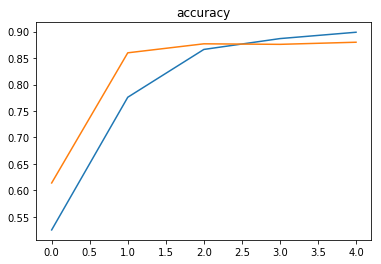

<Figure size 432x288 with 0 Axes>

In [126]:
plot_accuracy(history)

In [127]:

# with a Sequential model
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

In [128]:
layer_output = get_embed_out([x_val[0]])[0]

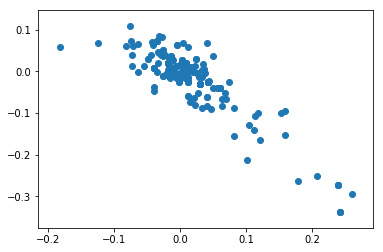

In [129]:
plt.scatter(layer_output[:,0], layer_output[:,1])

In [202]:
review = ['great', 'brilliant','crap','bad', 'tomato', 'fantastic', 'movie', 'seagal']
enc_review = [word_index[word] for word in review]
enc_review

[87, 530, 595, 78, 10373, 777, 20, 3272]

In [203]:
layer_output = get_embed_out([enc_review])[0]

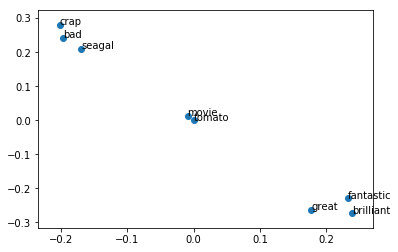

In [204]:
plt.scatter(layer_output[:,0], layer_output[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (layer_output[i,0], layer_output[i,1]))

In [182]:
def plot_review(i):
    layer_output = get_embed_out([x_val[i]])[0]
    plt.scatter(layer_output[:,0], layer_output[:,1])
    plt.title(y_val[i])
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5, 0.5])


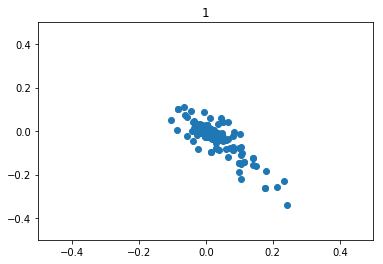

In [198]:
plot_review(16)